# **Saliford Motors project: Providing data-driven suggestions for HR**

### Preface

This project was developed as part of the **Google Advanced Data Analytics Course – Capstone Project (Course 7)**.  
The dataset used, `HR_capstone_dataset.csv`, is also provided through the course.

The main objective of this project is to address the business question:  
*"What factors are most likely to cause an employee to leave the company?"*

To answer this question, the project follows a four-step process:

1. **Data Exploration and Cleaning**  
   Initial analysis and preprocessing to understand the structure and quality of the data.

2. **Exploratory Data Analysis (EDA)**  
   Using visualizations to identify trends, patterns, and relationships between variables.

3. **Model Construction**  
   Building and comparing three classification models: Decision Tree, Random Forest, and XGBoost.

4. **Model Evaluation and Interpretation**  
   After identifying XGBoost as the best-performing model, its predictions will be interpreted using SHAP (SHapley Additive exPlanations) Beeswarm plot and built-in feature importance graph.

This structured approach aims to provide actionable insights into employee turnover and support data-driven decision-making for improving retention.

## Business scenario and problem

The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, but now they don’t know what to do with it. They have the following question: *what’s likely to make the employee leave the company?*

The goals of this project are to analyze the data collected by the HR department and to build a model that predicts whether or not an employee will leave the company.

## Step 1. Imports

*   Import packages
*   Load dataset

### Import packages

In [7]:
# Import packages
# Core Libraries
import os
import re
import pickle
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from xgboost import plot_importance

# Model Training
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model Evaluation & Tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Model Interpretation
import shap

### Load dataset

In [9]:
# Load dataset into a dataframe
df0 = pd.read_csv("HR_capstone_dataset.csv")
# Display first few rows of the dataframe
df0.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Step 2. Data Exploration (EDA and data cleaning)

In [11]:
# Gather basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [12]:
# Double checking missing values
df0.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

In [13]:
print("Empty rows:", df0.isnull().all(axis=1).sum())
print("Empty columns:", df0.isnull().all(axis=0).sum())

Empty rows: 0
Empty columns: 0


Data observations: No missing values were found in the dataset, as confirmed by .isna().sum(). All colums except "Department" and "Salary" are in integer or float types.

In [15]:
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


Data observations: data in columns with boolean infromation ("Work_accident", "left", "promotion_last_5years") entered without any errors

Converting column names to snake_case improves consistency and makes them easier to reference throughout the analysis.

In [18]:
# Renaming columns as needed
def to_snake_case(name):
    name = re.sub(r'(.)([A-Z][a-z]+)', r'\1_\2', name)       # camelCase → snake_case
    name = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', name)
    name = name.replace(" ", "_").replace("-", "_")          # spaces and hyphens → underscore
    return name.lower()

df0.columns = [to_snake_case(col) for col in df0.columns]

# Fixing a typo in a column name
df0.rename(columns={'average_montly_hours': 'average_monthly_hours'}, inplace=True)

# Displaying all column names after the update

df0.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

In [19]:
# Checking for duplicates
dupes = df0.duplicated(keep=False).sum()

In [20]:
duplicates = df0[df0.duplicated(keep=False)]
duplicates.sort_values(['average_monthly_hours'])

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
13401,0.28,0.89,4,97,6,0,0,0,management,low
11190,0.28,0.89,4,97,6,0,0,0,management,low
10848,0.83,0.86,4,98,4,0,0,0,sales,low
10809,0.51,0.74,6,98,3,0,0,0,support,low
13020,0.51,0.74,6,98,3,0,0,0,support,low
...,...,...,...,...,...,...,...,...,...,...
14972,0.11,0.97,6,310,4,0,1,0,accounting,medium
14777,0.11,0.79,7,310,4,0,1,0,hr,low
1936,0.11,0.97,6,310,4,0,1,0,accounting,medium
12566,0.11,0.79,7,310,4,0,1,0,hr,low


In [21]:
# Dropping duplicates
df = df0.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11991 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     11991 non-null  float64
 1   last_evaluation        11991 non-null  float64
 2   number_project         11991 non-null  int64  
 3   average_monthly_hours  11991 non-null  int64  
 4   time_spend_company     11991 non-null  int64  
 5   work_accident          11991 non-null  int64  
 6   left                   11991 non-null  int64  
 7   promotion_last_5years  11991 non-null  int64  
 8   department             11991 non-null  object 
 9   salary                 11991 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.0+ MB


After duplicate inspection, unnecessary entries were removed to ensure data quality moving forward.

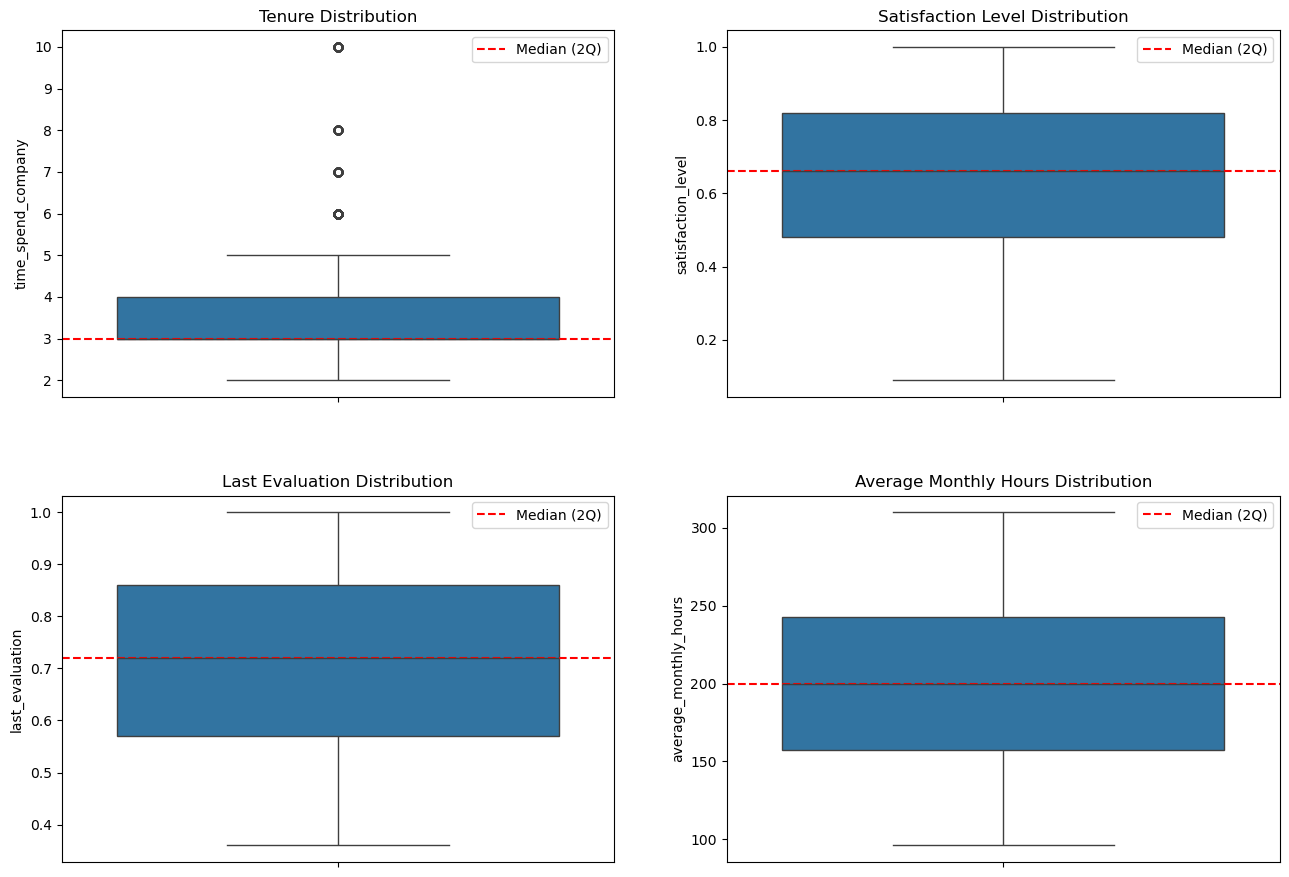

In [23]:
# Checking for outliers using box plots
cols = ['time_spend_company', 'satisfaction_level', 'last_evaluation', 'average_monthly_hours']
titles = ['Tenure Distribution', 'Satisfaction Level Distribution', 'Last Evaluation Distribution', 'Average Monthly Hours Distribution']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.tight_layout(pad=5)

for ax, col, title in zip(axes.flatten(), cols, titles):
    sns.boxplot(data=df[col], ax=ax)
    ax.axhline(df[col].median(), color='red', linestyle='--', label='Median (2Q)')
    ax.set_title(title)
    ax.legend()

plt.show()

In [24]:
# Checking number of outliers in time_spend_company
Q1 = df['time_spend_company'].quantile(0.25)
Q3 = df['time_spend_company'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['time_spend_company'] < Q1 - 1.5 * IQR) | (df['time_spend_company'] > Q3 + 1.5 * IQR)]
percentage = (len(outliers) / len(df)) * 100
print(f"Outliers in time_spend_company: {len(outliers)} rows")
print(f"Tenure Outlier Percentage: {percentage:.2f}%")

Outliers in time_spend_company: 824 rows
Tenure Outlier Percentage: 6.87%


In [25]:
# Dropping outliers
df = df[df['time_spend_company']<=5]

Only the tenure column shows presence of outliers. After careful examination, about **6.87%** of the rows were identified as outliers. Since this percentage is relatively small, these rows were removed to improve model accuracy.

In [27]:
# Checking how data is stratified in target variable
left_counts = df['left'].value_counts()
left_percentages = df['left'].value_counts(normalize=True) * 100  # Convert to percentage

print(" 'Left' Value Counts:")
print(f"Stayed (0): {left_counts[0]}")
print(f"Left   (1): {left_counts[1]}")

print("\n 'Left' Value Percentages:")
print(f"Stayed (0): {left_percentages[0]:.2f}%")
print(f"Left   (1): {left_percentages[1]:.2f}%")

 'Left' Value Counts:
Stayed (0): 9285
Left   (1): 1882

 'Left' Value Percentages:
Stayed (0): 83.15%
Left   (1): 16.85%


The goal of this project is to build a model that predicts whether an employee will leave the company. Therefore, our target variable is in the 'left' column.
Based on the results of the code above, it is evident that the data is unevenly stratified, with approximately 83% of employees staying and 17% leaving.
Although this class imbalance is not ideal, the data can still be used to build an effective model. However, it is important to take this imbalance into consideration when building the model and interpreting the results, especially for metrics like accuracy, which can be misleading in imbalanced datasets.

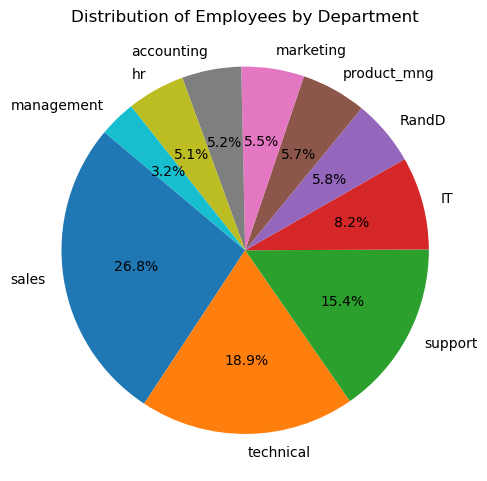

In [29]:
# Visualization of Department Distribution 
department_counts = df['department'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(department_counts, labels=department_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Employees by Department')
plt.axis('equal')  # Equal aspect ratio ensures the pie is a circle.
plt.tight_layout()
plt.show()

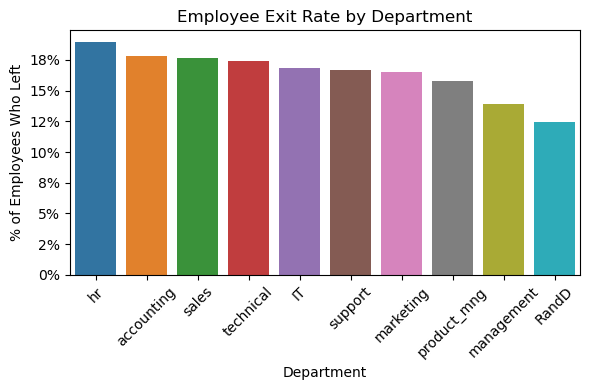

In [30]:
# Checking if exit rate differs by department
total_by_department = df.groupby('department').size().reset_index(name='total')
left_by_department = df[df['left'] == 1].groupby('department').size().reset_index(name='left_count')
dep_left_rate = pd.merge(total_by_department, left_by_department, on='department')
dep_left_rate['leave_rate'] = dep_left_rate['left_count'] / dep_left_rate['total']
dep_left_rate = dep_left_rate.sort_values(by='leave_rate', ascending=False)

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=dep_left_rate, x='department', y='leave_rate', hue='department')
plt.title('Employee Exit Rate by Department')
plt.xlabel('Department')
plt.ylabel('% of Employees Who Left')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.tight_layout()
plt.show()

After examining the 'department' column, it appears that the exit rates across all departments are fairly similar, ranging between 14% and 19%. However, this variable will still be included in the model to assess whether it has any impact.

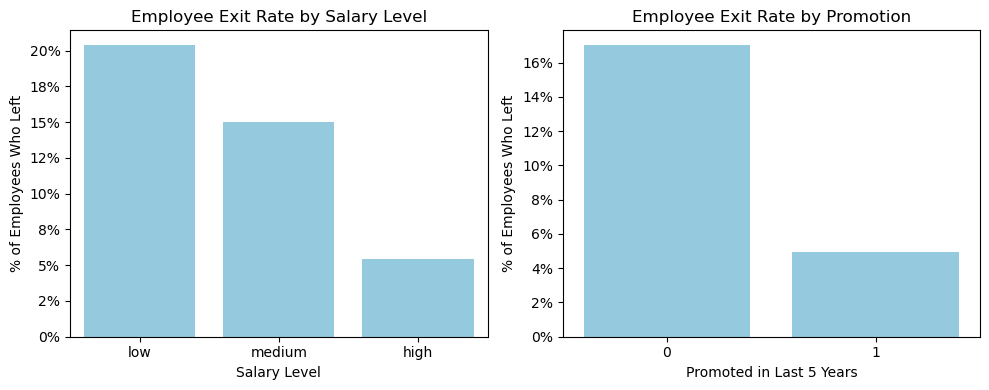

In [32]:
# Checking if leave rate differs by salary level
total_by_salary = df.groupby('salary').size().reset_index(name='total')
left_by_salary = df[df['left'] == 1].groupby('salary').size().reset_index(name='left_count')
salary_left_rate = pd.merge(total_by_salary, left_by_salary, on='salary')
salary_left_rate['leave_rate'] = salary_left_rate['left_count'] / salary_left_rate['total']
salary_left_rate = salary_left_rate.sort_values(by='leave_rate', ascending=False)

# Checking if leave rate differs by wheather or not employee was promoted
total_promoted = df.groupby('promotion_last_5years').size().reset_index(name='total')
left_by_promotion = df[df['left'] == 1].groupby('promotion_last_5years').size().reset_index(name='left_count')
promotion_left_rate = pd.merge(total_promoted, left_by_promotion, on='promotion_last_5years')
promotion_left_rate['leave_rate'] = promotion_left_rate['left_count'] / promotion_left_rate['total']
promotion_left_rate = promotion_left_rate.sort_values(by='leave_rate', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# Plot 1: Leave Rate by Salary Level
sns.barplot(data=salary_left_rate, x='salary', y='leave_rate', ax=axes[0], color='skyblue')
axes[0].set_title('Employee Exit Rate by Salary Level')
axes[0].set_xlabel('Salary Level')
axes[0].set_ylabel('% of Employees Who Left')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Plot 2: Leave Rate by Promotion in Last 5 Years
sns.barplot(data=promotion_left_rate, x='promotion_last_5years', y='leave_rate', ax=axes[1], color='skyblue')
axes[1].set_title('Employee Exit Rate by Promotion')
axes[1].set_xlabel('Promoted in Last 5 Years')
axes[1].set_ylabel('% of Employees Who Left')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

Employees with lower salaries and those who were not promoted exhibit a higher exit rate. This may indicate dissatisfaction with the company's salary and promotion policies. These variables could play a significant role in our model.

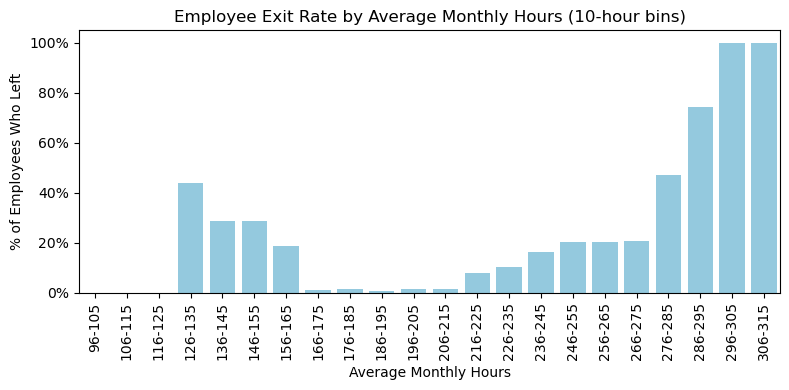

In [34]:
# Defining 10-hour bins
min_hour = df['average_monthly_hours'].min()
max_hour = df['average_monthly_hours'].max()

bins = np.arange(min_hour, max_hour + 10, 10)
labels = [f'{int(bins[i])}-{int(bins[i+1]-1)}' for i in range(len(bins) - 1)]

# Categorizing hours
df['hours_category'] = pd.cut(df['average_monthly_hours'], bins=bins, labels=labels, right=False)

# Calculating totals and peouple who left
total_by_hours = df.groupby('hours_category', observed=True).size().reset_index(name='total')
left_by_hours = df[df['left'] == 1].groupby('hours_category', observed=True).size().reset_index(name='left_count')

# Merge and safely fill missing values
hours_left_rate = pd.merge(total_by_hours, left_by_hours, on='hours_category', how='left')
hours_left_rate['left_count'] = hours_left_rate['left_count'].fillna(0)  # only fill this column
hours_left_rate['leave_rate'] = hours_left_rate['left_count'] / hours_left_rate['total']
hours_left_rate = hours_left_rate.sort_values(by='hours_category')

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(data=hours_left_rate, x='hours_category', y='leave_rate', color='skyblue')
plt.title('Employee Exit Rate by Average Monthly Hours (10-hour bins)')
plt.xlabel('Average Monthly Hours')
plt.ylabel('% of Employees Who Left')
plt.xticks(rotation=90)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.tight_layout()
plt.savefig(r'C:\Users\marie\Notebooks\Machine Learnig\leave_rate_by_hours.png')
plt.show()

This graph indicates that employees who work an average of 165 to 245 hours per month tend to have a higher retention rate.

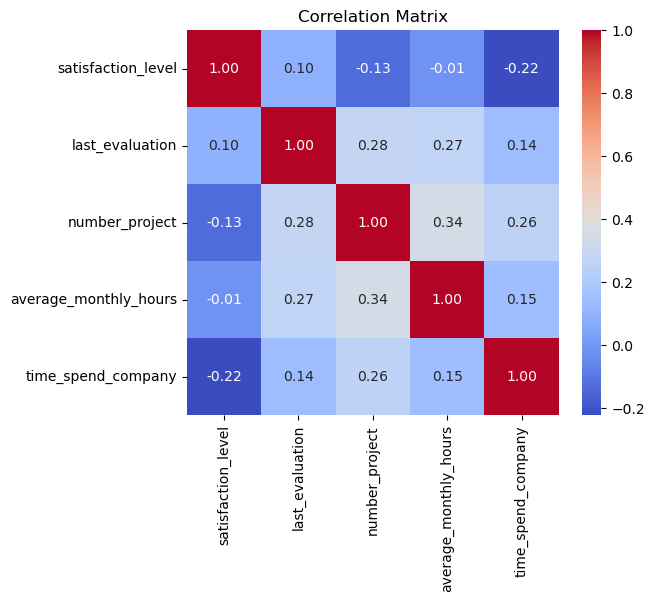

In [36]:
# Creating heatmap to check for correlation between numerical features
plt.figure(figsize=(6,5))
sns.heatmap(df[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'time_spend_company']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

The heatmap helps identify whether numeric columns are correlated. The closer the value is to 0, the weaker the correlation between two variables. Among the features, average monthly hours and number of projects appear to be the most correlated. It would be useful to investigate their relationship further.

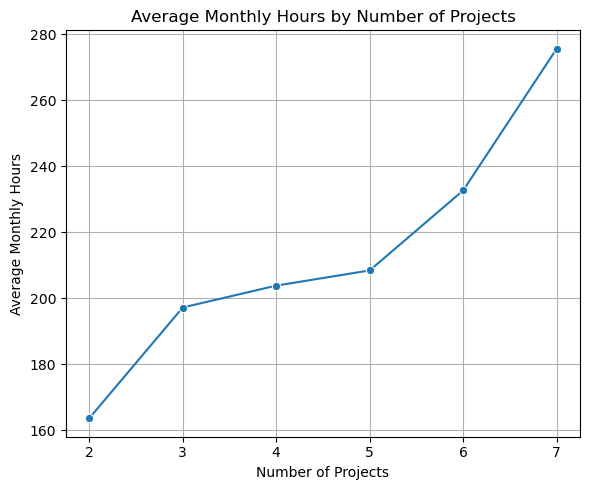

In [38]:
# Further inspecting correlation between hours and number of projects
# Calculating mean monthly hours per project count
grouped = df.groupby('number_project')['average_monthly_hours'].mean().reset_index()

# Plot
plt.figure(figsize=(6, 5))
sns.lineplot(data=grouped, x='number_project', y='average_monthly_hours', marker='o')
plt.title('Average Monthly Hours by Number of Projects')
plt.xlabel('Number of Projects')
plt.ylabel('Average Monthly Hours')
plt.grid(True)
plt.tight_layout()
plt.show()

As expected, the 'average_monthly_hours' and 'number_project' columns are correlated. This correlation can negatively impact the model we are building. Since 'number_project' is a less important predictor, it would be better to drop it from the model.

In [40]:
# Dropping irrelevant column
df = df.drop('number_project', axis = 1)

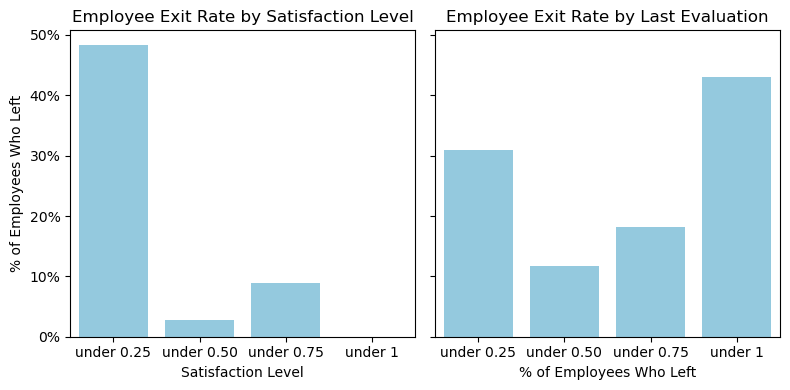

In [41]:
# Binning satisfaction_level
bins_sat = [0.25, 0.50, 0.75, 1, float('inf')]
labels_sat = ['under 0.25', 'under 0.50', 'under 0.75', 'under 1']
df['satisfaction_category'] = pd.cut(df['satisfaction_level'], bins=bins_sat, labels=labels_sat, right=False)

# Binning last_evaluation
bins_eval = [0.25, 0.50, 0.75, 1, float('inf')]
labels_eval = ['under 0.25', 'under 0.50', 'under 0.75', 'under 1']
df['evaluation_category'] = pd.cut(df['last_evaluation'], bins=bins_eval, labels=labels_eval, right=False)

# Leave rate by satisfaction
total_by_sat = df.groupby('satisfaction_category', observed=True).size().reset_index(name='total')
left_by_sat = df[df['left'] == 1].groupby('satisfaction_category', observed=True).size().reset_index(name='left_count')
sat_left_rate = pd.merge(total_by_sat, left_by_sat, on='satisfaction_category')
sat_left_rate['leave_rate'] = sat_left_rate['left_count'] / sat_left_rate['total']

# Leave rate by last evaluation
total_by_eval = df.groupby('evaluation_category', observed=True).size().reset_index(name='total')
left_by_eval = df[df['left'] == 1].groupby('evaluation_category', observed=True).size().reset_index(name='left_count')
eval_left_rate = pd.merge(total_by_eval, left_by_eval, on='evaluation_category')
eval_left_rate['leave_rate'] = eval_left_rate['left_count'] / eval_left_rate['total']

# Plot
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

sns.barplot(data=sat_left_rate, x='satisfaction_category', y='leave_rate', ax=axes[0], color='skyblue')
axes[0].set_title('Employee Exit Rate by Satisfaction Level')
axes[0].set_xlabel('Satisfaction Level')
axes[0].set_ylabel('% of Employees Who Left')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

sns.barplot(data=eval_left_rate, x='evaluation_category', y='leave_rate', ax=axes[1], color='skyblue')
axes[1].set_title('Employee Exit Rate by Last Evaluation')
axes[1].set_xlabel('% of Employees Who Left')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

The barchart above indicates that both satisfaction level and last evaluation score impact employee retention.

<Axes: xlabel='salary', ylabel='satisfaction_level'>

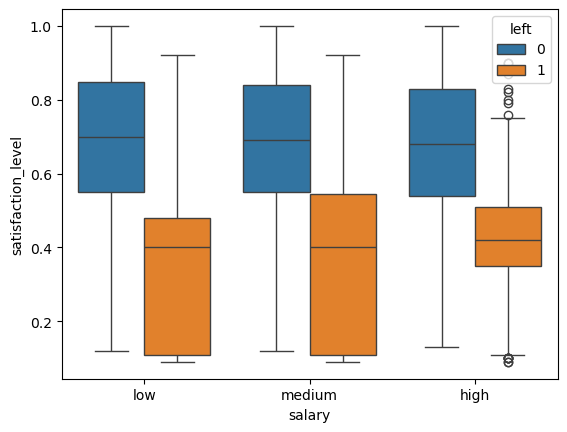

In [43]:
# Distribution of satisfaction level by salary
sns.boxplot(x='salary', y='satisfaction_level', hue='left', data=df)

The boxplot above indicates that employees with lower satisfaction levels are more likely to leave, regardless of their salary level. This suggests that salary level alone is not the primary factor influencing employee turnover.

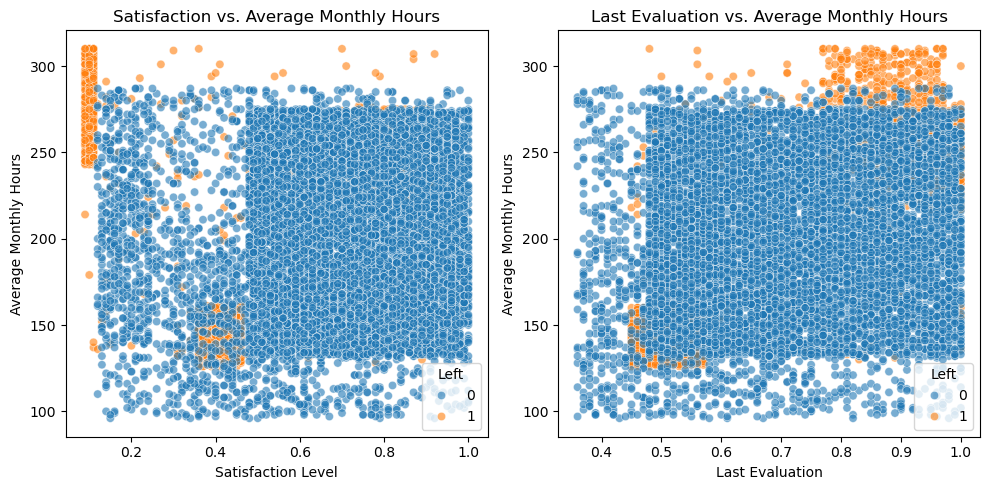

In [45]:
plt.figure(figsize=(10, 5))

# Satisfaction vs Hours
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='satisfaction_level', y='average_monthly_hours', hue='left', alpha=0.6)
plt.title('Satisfaction vs. Average Monthly Hours')
plt.xlabel('Satisfaction Level')
plt.ylabel('Average Monthly Hours')
plt.legend(title='Left', loc='lower right')

# Evaluation vs Hours
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='last_evaluation', y='average_monthly_hours', hue='left', alpha=0.6)
plt.title('Last Evaluation vs. Average Monthly Hours')
plt.xlabel('Last Evaluation')
plt.ylabel('Average Monthly Hours')
plt.legend(title='Left', loc='lower right')

plt.tight_layout()
plt.show()

Analyzing scatter plots of satisfaction level vs. average monthly hours and last evaluation vs. average monthly hours did not reveal a clear relationship suggesting that average monthly hours directly affect employee satisfaction or evaluation scores.
However, graph indicates that employees who worked longer hours were more likely to leave the company, even when their evaluation scores were high.

### Final Feature Engineering

After a thorough examination of the dataset, the predictor variables selected for the model are:
satisfaction_level, last_evaluation, average_monthly_hours, time_spent_company, work_accident, and promotion_last_5years.
In the final step, helper columns will be removed, and the categorical columns department and salary will be dummy encoded as required for building tree-based models.

In [49]:
# Dropping helper columns that are irrelevant for the future model
df_fin = df.drop(['hours_category', 'satisfaction_category', 'evaluation_category'], axis =1)
# Dummy encoding categorical variables
df_fin = pd.get_dummies(df_fin, drop_first=True)

df_fin.head()

,satisfaction_level,last_evaluation,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.38,0.53,157,3,0,1,0,False,False,False,False,False,False,True,False,False,True,False
2,0.11,0.88,272,4,0,1,0,False,False,False,False,False,False,True,False,False,False,True
3,0.72,0.87,223,5,0,1,0,False,False,False,False,False,False,True,False,False,True,False
4,0.37,0.52,159,3,0,1,0,False,False,False,False,False,False,True,False,False,True,False
5,0.41,0.50,153,3,0,1,0,False,False,False,False,False,False,True,False,False,True,False


In [50]:
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11167 entries, 0 to 11999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   satisfaction_level      11167 non-null  float64
 1   last_evaluation         11167 non-null  float64
 2   average_monthly_hours   11167 non-null  int64  
 3   time_spend_company      11167 non-null  int64  
 4   work_accident           11167 non-null  int64  
 5   left                    11167 non-null  int64  
 6   promotion_last_5years   11167 non-null  int64  
 7   department_RandD        11167 non-null  bool   
 8   department_accounting   11167 non-null  bool   
 9   department_hr           11167 non-null  bool   
 10  department_management   11167 non-null  bool   
 11  department_marketing    11167 non-null  bool   
 12  department_product_mng  11167 non-null  bool   
 13  department_sales        11167 non-null  bool   
 14  department_support      11167 non-null  boo

**Note:** Some models require data to be scaled. However, the model chosen for this project does not, so this step will be skipped.

## Step 3. Constructing the model

**Selecting the Appropriate Model Type**

A tree-based model was selected for this project due to its ability to handle non-linear relationships, as observed in our graphs linking leave rate to satisfaction level and evaluation score. It also performs well with mixed data types, as present in our final dataset. Additionally, it offers higher predictive performance than simpler models (e.g., logistic regression) and provides interpretable measures of feature importance, helping us understand which features most significantly impact the target variable.

Three types of tree-based models will be built and their results compared: Decision Tree, Random Forest, and XGBoost. All models will be tuned using GridSearch, a hyperparameter tuning technique that employs cross-validation to identify the best combination of parameters for each model.

**Evaluation Metrics**

The F1 score will be used as the target metric for this project, as it balances Precision (the percentage of correct predictions among all positive predictions) and Recall (the percentage of actual positives correctly identified). This helps us achieve more reliable results, since both false negatives and false positives can negatively impact decision-making.

Along with the target metric, additional metrics will be presented for reference:

1. Recall – The percentage of actual positives that the model correctly identifies.
2. Precision – The percentage of positive predictions that are actually correct.
3. Accuracy – The overall percentage of correct predictions (both positive and negative).

In [56]:
# Defining target variable (y) and predictor variables (X)
y = df_fin['left']
X = df_fin.copy()
X = X.drop('left', axis = 1)

In [57]:
# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.2, random_state=42)

A 20/80 train-test split was chosen to ensure that the model has sufficient data to learn from, especially important in imbalanced datasets where the minority class is underrepresented. Using 80% of the data for training provides enough examples for the model to capture complex patterns, while reserving 20% for testing offers a reliable and unbiased evaluation of model performance. Additionally, the data was stratified to preserve the class imbalance in both sets.

### Decision Tree

Given a dataset with over 11,000 samples and moderate class imbalance, the hyperparameters were chosen to find a balance between overfitting and underfitting and make sure that class imbalance will not skew the results. 

In [61]:
# Assigning a dictionary of hyperparameters to search over
tree_para = {
    'max_depth': [3, 5, 10, None],          # Covers both shallow (to avoid overfitting) and deep trees (to capture complex patterns).
    'min_samples_split': [2, 5, 10],        # Increasing this value helps regularize the model, reducing sensitivity to noise 
                                            # and class imbalance in smaller branches.
    'min_samples_leaf': [1, 2, 4],          # Prevents the model from forming leaves with very few samples.
    'class_weight': [None, 'balanced']      # Crucial for imbalanced datasets. 
}

# Assigning a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# Instantiating the classifier
tuned_decision_tree = DecisionTreeClassifier(random_state = 42)

# Instantiating the GridSearch
clf = GridSearchCV(tuned_decision_tree, tree_para, scoring = scoring, cv=5, refit="f1")

# Fit the model
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [3, 5, 10, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [62]:
# Indentifying best parameters
clf.best_params_

{'class_weight': None,
 'max_depth': 10,
 'min_samples_leaf': 4,
 'min_samples_split': 10}

In [63]:
# Indentifying best score
print("Best Avg. Validation Score: ", "%.4f" % clf.best_score_)

Best Avg. Validation Score:  0.9352


This is a strong F1 score, indicating that the model has a low number of false positives and false negatives.

In [65]:
# Creating a table to store results for all of the models
def make_results(model_name, model_object):
     # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                        'F1': [f1],
                        'Recall': [recall],
                        'Precision': [precision],
                        'Accuracy': [accuracy]
                         }
                        )
  
    return table

In [66]:
result_table = make_results("Decision Tree CV", clf)

### Random Forest

Given a dataset with over 11,000 samples and moderate class imbalance, the hyperparameters were chosen to find a balance between overfitting and underfitting and make sure that class imbalance will not skew the results.

In [69]:
# Instantiating the model
rf = RandomForestClassifier(random_state=42)

# Assigning a dictionary of hyperparameters to search over
cv_params = {
    'n_estimators': [100, 200, 500],        # Number of trees in the forest. More trees can improve performance but increase computation.               
    'max_depth': [10, 20, None],            # Covers both shallow (to avoid overfitting) and deep trees (to capture complex patterns).                  
    'min_samples_split': [2, 5, 10],        # Increasing this value helps regularize the model, reducing sensitivity to noise 
                                            # and class imbalance in smaller branches.      
    'min_samples_leaf': [1, 2, 4],          # Prevents the model from forming leaves with very few samples.      
    'max_features': ['sqrt', 'log2'],       # Controls number of features considered at each split. Helps decorrelate trees and reduce variance.       
    'class_weight': [None, 'balanced']      # Addresses class imbalance (17% "left"). 'balanced' improves recall for minority class.       
}

# Assigning a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
    }

# Instantiating the GridSearch
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1')

# Fitting the model
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [10, 20, None],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [70]:
# Pickling the model for future convinience
path = r'C:\Users\marie\Notebooks\Machine Learnig\Pickle'
os.makedirs(path, exist_ok=True)
with open(os.path.join(path, 'rf_cv_model.pickle'), 'wb') as to_write:
    pickle.dump(rf_cv, to_write)

In [71]:
# Indentifying best parameters
rf_cv.best_params_

{'class_weight': None,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}

In [72]:
# Indentifying best score
print("Best Avg. Validation Score: ", "%.4f" % rf_cv.best_score_)

Best Avg. Validation Score:  0.9472


This is a strong F1 score, indicating that the model has a low number of false positives and false negatives.

In [74]:
# Adding to the results table
rf_cv_results = make_results('Random Forest CV', rf_cv)
rf_cv_results
result_table = pd.concat([rf_cv_results, result_table])

### XGBoost

Given a dataset with over 11,000 samples and moderate class imbalance, the hyperparameters were chosen to find a balance between overfitting and underfitting and make sure that class imbalance will not skew the results.

In [77]:
# Instantiating the model
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# Assigning a dictionary of hyperparameters to search over
cv_params = {
    'n_estimators': [100, 200, 300],            # Number of trees in the forest. More trees can improve performance but increase computation.    
    'learning_rate': [0.01, 0.1, 0.3],          # Smaller values slow learning but improve generalization, 
                                                # larger values can speed up training but risk overfitting.  
    'max_depth': [3, 5, 7],                     # Covers both shallow (to avoid overfitting) and deep trees (to capture complex patterns).
    'min_child_weight': [1, 3, 5],              # Higher values make the algorithm less prone to overfitting.  
    'scale_pos_weight': [1, 4, 5]               # Addresses class imbalance.  
}


# Assigning a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# Instantiating the GridSearch
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')

# Fitting the model
xgb_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 300],
                         'scale_pos_weight': [1, 4, 5]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [78]:
# Pickling the model for future convinience
path = r'C:\Users\marie\Notebooks\Machine Learnig\Pickle'
os.makedirs(path, exist_ok=True)
with open(os.path.join(path, 'xgb_cv_model.pickle'), 'wb') as to_write:
    pickle.dump(xgb_cv, to_write)

In [79]:
# Indentifying best parameters
rf_cv.best_params_

{'class_weight': None,
 'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 200}

In [80]:
# Indentifying best score
print("Best Avg. Validation Score: ", "%.4f" % xgb_cv.best_score_)

Best Avg. Validation Score:  0.9469


This is a strong F1 score, indicating that the model has a low number of false positives and false negatives.

In [82]:
# Adding to the results table
xgb_cv_results = make_results('XGBoost CV', xgb_cv)
xgb_cv_results
result_table = pd.concat([xgb_cv_results, result_table])

# Step 4. Results and Evaluation

In [84]:
# Helper function to plot confusion matrix
def conf_matrix_plot(models: dict, x_data, y_data):
     n = len(models)
     fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))  

     if n == 1:
        axes = [axes]  

     for ax, (name, model) in zip(axes, models.items()):
        y_pred = model.predict(x_data)
        cm = confusion_matrix(y_data, y_pred, labels=model.classes_)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        disp.plot(ax=ax, colorbar=True)
        ax.set_title(name)

     plt.tight_layout()
     plt.show()

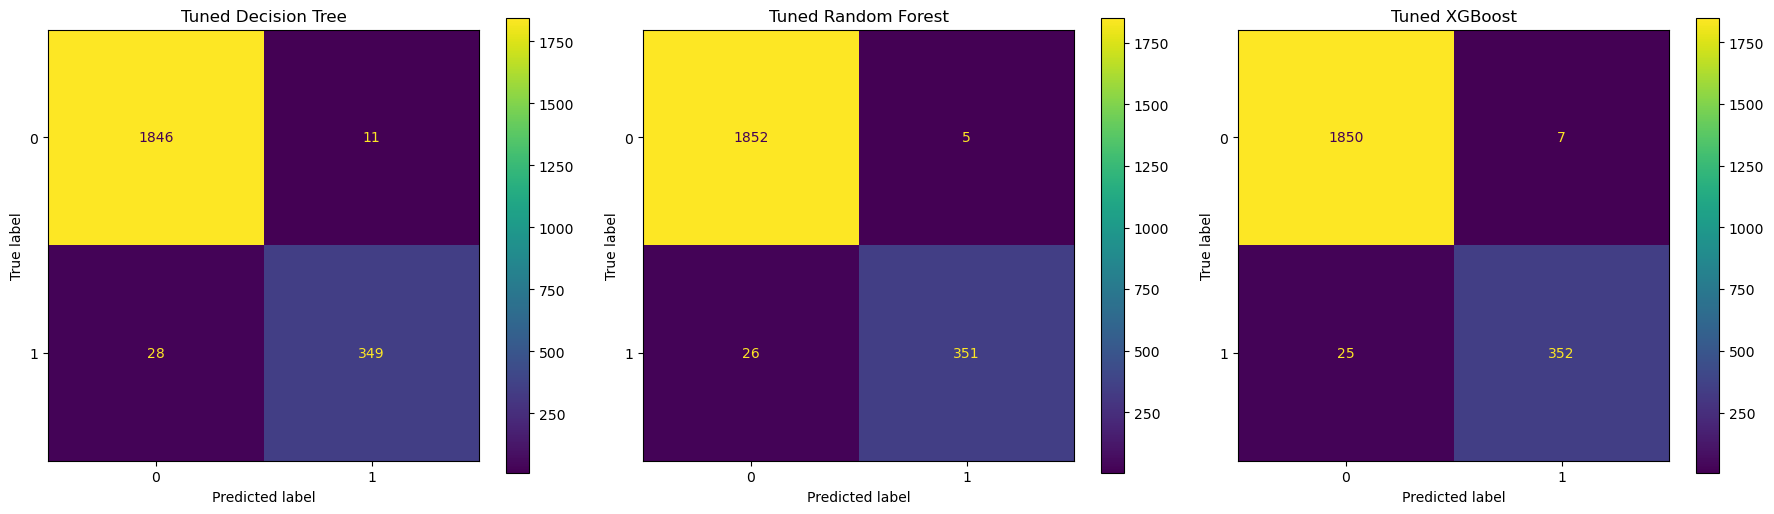

In [85]:
models = {
    "Tuned Decision Tree": clf,
    "Tuned Random Forest": rf_cv,
    "Tuned XGBoost": xgb_cv
}

conf_matrix_plot(models, X_test, y_test)

In [86]:
result_table

,Model,F1,Recall,Precision,Accuracy
0,XGBoost CV,0.946920,0.913621,0.982843,0.982760
0,Random Forest CV,0.947159,0.912292,0.984919,0.982872
0,Decision Tree CV,0.935175,0.910963,0.960815,0.978730


Based on the confusion matrix plots and the results table, both the XGBoost and Random Forest models achieved strong performance, with F1 scores of 0.95 (where 0.75 is often considered an acceptable benchmark). Although their overall metrics are similar, the confusion matrix shows that the XGBoost model has the fewest false negatives, indicating higher recall. A key advantage of XGBoost is that it supports both SHAP analysis and built-in feature importance methods, making it especially useful for interpreting model behavior and identifying the most influential features. Therefore, the XGBoost model is selected for final interpretation and feature analysis.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

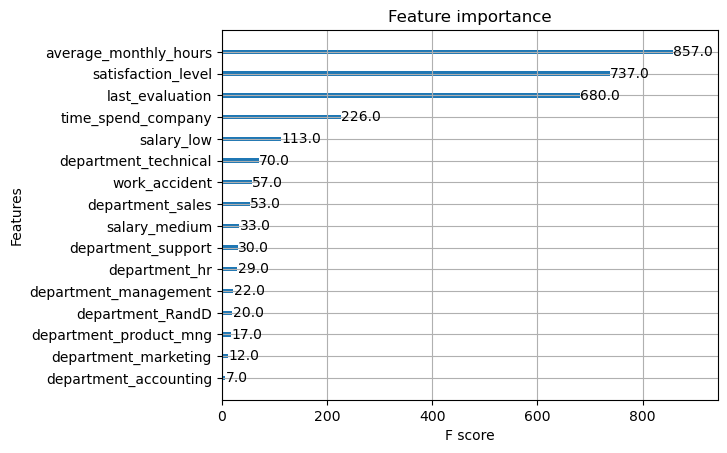

In [88]:
# Featue importance plot 
plot_importance(xgb_cv.best_estimator_)

Initial feature importance analysis identified the three most impactful factors for employee retention as average monthly hours, satisfaction level, and last evaluation score. While the feature importance graph highlights the relative influence of these variables, it does not explain how their values affect the target variable. To provide this insight, the SHAP beeswarm plot is presented below.

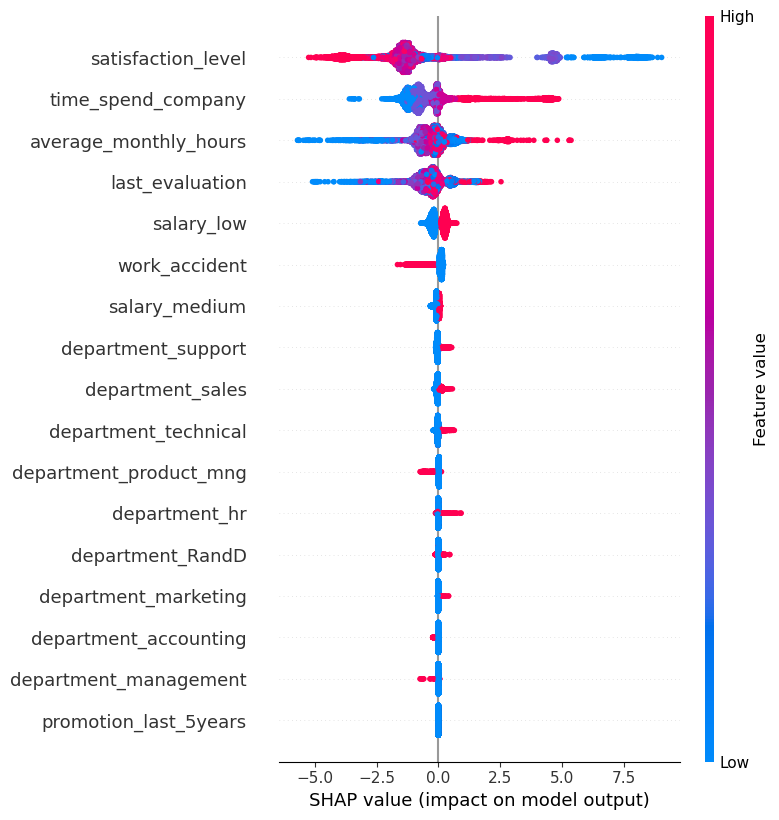

In [90]:
best_model = xgb_cv.best_estimator_  # xgb_cv is your GridSearchCV object
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

The plot highlights the five most influential factors the model used to determine whether an employee would stay or leave the company:

- **Satisfaction Level**  
  Employees with lower satisfaction levels were significantly more likely to leave the company compared to those who were more satisfied.

- **Tenure**  
  The company appears to have a high turnover rate, as employees with longer tenure were more likely to leave.

- **Average Monthly Working Hours**  
  As shown in the graph, employees with both extremely high and extremely low average monthly hours were more likely to leave.

- **Last Evaluation**  
  Interestingly, employees with higher performance evaluation scores also showed a higher exit rate.

- **Salary Level**  
  Salary level was another important predictor. Employees with low salaries were much more likely to leave the company.

## Business recommendations based on the analysis

**1. Employee Satisfaction Level Survey**

Conduct an anonymous satisfaction level survey that asks employees what improvements they believe are needed to increase their satisfaction, especially if it is currently low. This approach aims to provide a clearer understanding of the underlying issues and to support strategies for improving overall employee satisfaction.

**2. Turnover Rate**

As shown in the graph below, more than 15% of employees who reach 3 years at the company have left, with the exit rate spiking to over 40% for those who reach the 5-year mark. It is recommended that the company focuses on retaining these experienced employees. One possible solution could be introducing a new promotion policy for those who have been with the company for more than 3 years.

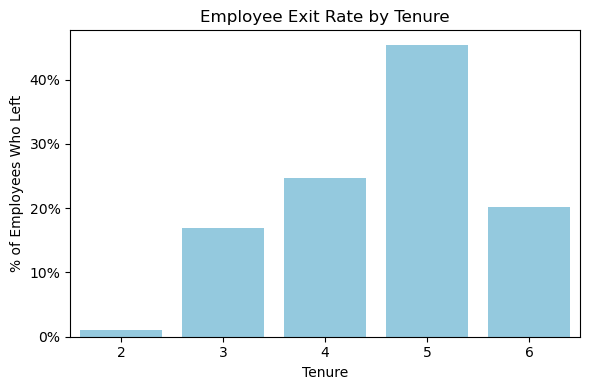

In [95]:
df3 = df0.drop_duplicates()
# Checking if exit rate differs by tenure
total_by_tenure = df3.groupby('time_spend_company').size().reset_index(name='total')
left_by_tenure = df3[df3['left'] == 1].groupby('time_spend_company').size().reset_index(name='left_count')
t_left_rate = pd.merge(total_by_tenure, left_by_tenure, on='time_spend_company')
t_left_rate['leave_rate'] = t_left_rate['left_count'] / t_left_rate['total']
t_left_rate = t_left_rate.sort_values(by='leave_rate', ascending=False)

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=t_left_rate, x='time_spend_company', y='leave_rate', color='skyblue')
plt.title('Employee Exit Rate by Tenure')
plt.xlabel('Tenure')
plt.ylabel('% of Employees Who Left')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.tight_layout()
plt.show()

**3. Work Hour Regulation Policy**

SHAP analysis showed that both employees with low and high monthly working hours were more likely to leave the company. For a clearer understanding, refer to the graph below.

The graph indicates that the "sweet spot"—where the employee exit rate is closest to zero—is between **166 and 215 hours** per month. If we broaden this range, the **156–275 hour** window still maintains an acceptable turnover rate of around 20%.

It is recommended that the company regulates working hours to fall within one of these suggested ranges. This can be achieved by discouraging employees from working overtime or by capping the number of projects an employee can be assigned.

![Exit Rate Plot](exit_rate_by_hours.png)

**4. Bonus and Rewards**

SHAP analysis showed that employees with high evaluation scores are more likely to leave. A possible reason is that their efforts may not be properly recognized.

The company should check if high-performing employees are getting enough recognition. If not, it is recommended to create a bonus or reward system to help keep top-performing staff motivated and loyal.

**5. Review of Salary Policy**

Another factor contributing to the low retention rate is salary. According to the dataset, 47.87% of employees fall into the low salary category. This group has an exit rate of approximately 20%, as shown in the graph below.

To address this issue, it is recommended that the company reevaluate its salary policy by conducting market research to ensure that compensation is competitive and aligned with industry standards.

In [100]:
print("\n'Salary' Value Percentages:")
salary_percentages = df3['salary'].value_counts(normalize=True) * 100
for value, percent in salary_percentages.items():
    print(f"{value}: {percent:.2f}%")


'Salary' Value Percentages:
low: 47.87%
medium: 43.87%
high: 8.26%


![Exit Rate by Salary Level](exit_rate_by_salary_level.jpg)

***Bonus Point – Impact of Work Accidents on Retention***

The SHAP beeswarm plot indicated that employees who experienced a work accident were less likely to leave the company. One possible explanation is that these employees received additional support following the incident, which increased their sense of security and loyalty to the organization.

This finding suggests that the company's crisis response policies are effective. To further improve retention, it is recommended that similar levels of support, guidance, or check-ins be extended to all employees—not just those involved in accidents.

## Summary Table

In [104]:
data = {
    'Feature': ['Satisfaction Level', 'Time in Company', 'Monthly Hours', 'Evaluation Score', 'Salary'],
    'Insight': [
        'Lower satisfaction = higher exit risk',
        'Long tenure without promotion = higher risk',
        'Unhealthy working hours → potential burnout',
        'Unrecognized employees → risk of losing talent',
        'Uncompetitive compensation levels → lower retention rates'
    ],
    'Recommendation': [
        'Conduct quarterly surveys and 1:1 meetings',
        'Define career paths and make sure promotions are fair',
        'Promote work-life balance and offer flexible hours',
        'Ensure top-performing employees are rewarded accordingly',
        'Review market pay levels and adjust policies if needed'
    ]
}

# Convert dictionary to DataFrame
conclusion_summary = pd.DataFrame(data)

# Display the table
conclusion_summary.style.hide(axis='index')

Feature,Insight,Recommendation
Satisfaction Level,Lower satisfaction = higher exit risk,Conduct quarterly surveys and 1:1 meetings
Time in Company,Long tenure without promotion = higher risk,Define career paths and make sure promotions are fair
Monthly Hours,Unhealthy working hours → potential burnout,Promote work-life balance and offer flexible hours
Evaluation Score,Unrecognized employees → risk of losing talent,Ensure top-performing employees are rewarded accordingly
Salary,Uncompetitive compensation levels → lower retention rates,Review market pay levels and adjust policies if needed


**Note:** This research was conducted using only the data available to the HR department to avoid data leakage.